### The purpose of this notebook is to create and examine a method called high-level-transformation. 
The goal of High-Level Extraction is to represent a neural network model at the level of its layer labels. 
This means that the model is run through and each torch.nn.module is checked for its actual class. Then it is distinguished whether the module is a container or an actual module.
The chosen approach is that optionally a maximum depth can be provided (The default max-depth is 1). With a depth of 0, just the name of the network as a single node is the output. With a depth of 1, the label of each child of the model is represented as a node and linked in descending order. Maximum depths greater than 1 are executed until either the set maximum depth is reached or the actual child is a module without further children. 
Each module is visualized with an angular node, which has the class name as its label.  

Dr. Thomas Viehmann already implemented an interesting similar approach. My implementation will base on his one. Therefore, for the creation process i will use the ResNet18 model as he did. 

In [62]:
import torchvision
model = torchvision.models.resnet18()

Lets take a look at the attributes of this model

In [63]:
model.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('conv1',
               Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
              ('bn1',
               BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
              ('relu', ReLU(inplace=True)),
              ('maxpool',
               MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
              ('layer1',
               Sequential(
                 (0): BasicBlock(
                   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

As we can see there is a attribute called _modules which is interesting for us.

Lets take a look at these _modules

In [64]:
model.__dict__.get("_modules")


OrderedDict([('conv1',
              Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
             ('bn1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('relu', ReLU(inplace=True)),
             ('maxpool',
              MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
             ('layer1',
              Sequential(
                (0): BasicBlock(
                  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (relu): ReLU(inplace=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
                (1): BasicBlock(
         

This already looks promising.
Lets take a look at the forward method

In [ ]:
import inspect
print(inspect.getsource(model.forward))
print(inspect.getsource(model._forward_impl))

The output from the dict looks like the detailed version of the forward function. But as we can see the torch.flatten function is not viewable with the dict, because it's not a member of the class. Flatten is not interesting anyway, because it just reshapes the input tensor. But Dr. Thomas Viehmann pointed out that some behaviour is hidden in the neat string representation of PyTorch modules as we can see in the following. [cite viehmann blogpost] 

In [ ]:
print(model.layer1[0])
print(inspect.getsource(model.layer1[0].forward))

If we compare the two outputs we recognize that relu is used twice, but only mentioned once. Also the addition of the identity is missing. 
Here the question arises if this has to be in our graph representation. 
On one hand side, this does matter if we try to understand how the model is working. 
But is there a reason not to include them because they dont matter for structural analysis? -> ask julian

#### Implementation
Lets try to implement a function that looks at the forward function and views the operations as nodes with label names of the operations for a max-depth of 1.
We should get the output of: "print(inspect.getsource(model._forward_impl))" as a graph

In [58]:
import torch
import networkx as nx

def transform(model: torch.nn.Module, depth=1, ignored_modules=None, split_modules=None):
    if split_modules is None:
        split_modules = []
    if ignored_modules is None:
        ignored_modules = []
    graph = nx.DiGraph()
    pos = {}
    next_node = 0
    instances_with_children = [torch.nn.ModuleList, torch.nn.Sequential, torch.nn.ModuleDict]
    for name, module in model.named_children():
        print('First transform method. Touched module: ' + ' with name ' + name)
        print(module)
        is_instance_with_children = any(isinstance(module, i) for i in instances_with_children)
        next_node = transform_container_module(module, name, depth, graph, pos,
                                        next_node) if is_instance_with_children else transform_module(graph,
                                                                                                     next_node,
                                                                                                     name, pos)
    return graph, pos


def transform_container_module(module, name, level, graph, pos,
                               next_node_index):  # TODO: decide if container module should be added as node, current impl does not add it, because this could lead to confusion
    sub_graph, last_node = transform_child(module, graph, level, next_node_index, pos)
    connect_subgraph_to_graph(graph, sub_graph, next_node_index)
    return last_node


def transform_module(graph, current_node, name, pos):
    print('added to graph: ' + name)
    graph.add_node(current_node, name=name)
    pos[current_node] = (0, current_node)
    connect_with_prev_node(graph, current_node)
    return current_node + 1


def transform_child(module: torch.nn.Module, graph, depth, current_node, pos):  # TODO: implement level check
    updated_graph = graph
    last_node = current_node
    for name, child in module.named_children():  # in sequential blocks haben die children nicht immer namen und können deswegen nummern sein
        updated_graph, last_node = transform_partial(child, name, depth, updated_graph, last_node, pos)
    return updated_graph, last_node


def transform_partial(module: torch.nn.Module, name, depth, initial_graph, next_node_index, pos):
    graph = initial_graph
    next_node = next_node_index
    instances_with_children = [torch.nn.ModuleList, torch.nn.Sequential, torch.nn.ModuleDict]
    is_instance_with_children = any(isinstance(module, i) for i in instances_with_children)
    next_node = transform_container_module(module, name, depth, graph, pos,
                                           next_node) if is_instance_with_children else transform_module(graph,
                                                                                                         next_node,
                                                                                                         name, pos)
    return graph, next_node


def connect_subgraph_to_graph(graph, sub_graph, current_node):
    graph.add_nodes_from(sub_graph.nodes(data=True))
    graph.add_edges_from(sub_graph.edges(data=True))
    connect_with_prev_node(graph, current_node + 1)


def connect_with_prev_node(graph, current_node):
    if current_node > 0:
        graph.add_edge(current_node - 1, current_node)

First transform method. Touched module:  with name conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
added to graph: conv1
First transform method. Touched module:  with name bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
added to graph: bn1
First transform method. Touched module:  with name relu
ReLU(inplace=True)
added to graph: relu
First transform method. Touched module:  with name maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
added to graph: maxpool
First transform method. Touched module:  with name layer1
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, mome

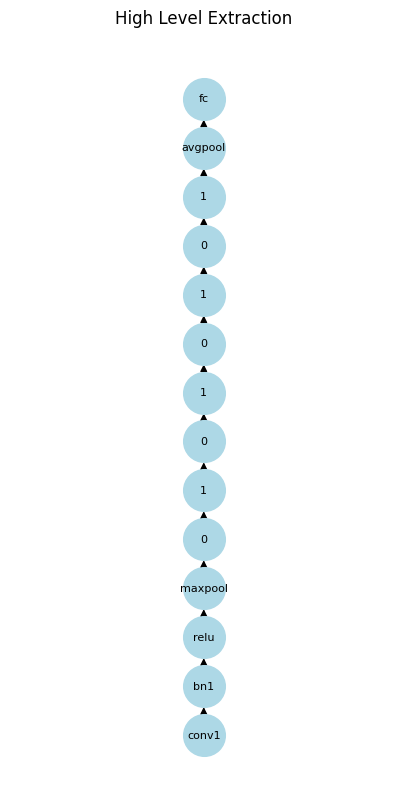

In [59]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_graph(graph, title, positions):
    labels = {node: graph.nodes[node]['name'] for node in graph.nodes()}
    fig, ax = plt.subplots(figsize=(5, 10))
    nx.draw(graph, positions, labels=labels, with_labels=True, node_size=900, node_color='lightblue', font_size=8, ax=ax)
    plt.title(title)
    plt.show()
    
g, p = transform(model)
print(g)
plot_graph(g, "High Level Extraction", p)

We notice that basic blocks are specific containers which inhere fromm torch.Module. As developers can create their specific type of organisation within a neural network, we should split up all torch.Modules recursively instead of just splitting up torch.nn.ModuleList, torch.nn.Sequential, torch.nn.ModuleDict.
Lets try another approach:
 

In [69]:
import torch
import networkx as nx
import torchvision.models
from torch import nn
import matplotlib.pyplot as plt

class GraphTransformer:
    def __init__(self, shown_modules=None, split_modules=None, ignored_modules=None):
        self.shown_modules = shown_modules
        self.split_modules = split_modules
        self.ignored_modules = ignored_modules if ignored_modules is not None else []
        self.pos = {}
        self.graph = nx.DiGraph()
        self.next_node_index = 0

    def transform(self, model: torch.nn.Module, depth=1): 
        for module in model.children(): # TODO: Hier vielleicht mit JIT.trace arbeiten?
            self.classify_module(module, depth)

    def classify_module(self, module, depth):
        name = type(module).__name__
        if any(isinstance(module, i) for i in self.ignored_modules):
            return
        if self.split_modules is None or any(isinstance(module, i) for i in self.split_modules):
            for child in module.children():
                self.classify_module(child, depth) 
            # TODO: Die modules müssen auf neuronen ebene wie im low-level dargestellt werden
        if self.shown_modules is None or any(isinstance(module, i) for i in self.shown_modules): # TODO: hier eigentlich elseif
            self._add_node(name) 
        else:
            print("This module is not considered: " + name)

    def _add_node(self, name):
        current_node = self.next_node_index
        prev_node = self.next_node_index - 1
        self.graph.add_node(current_node, name=name)
        nodes = self.graph.nodes()
        if prev_node in nodes and current_node in nodes:
            self.graph.add_edge(prev_node, current_node)
        self.pos[current_node] = (0, current_node)
        self.next_node_index += 1

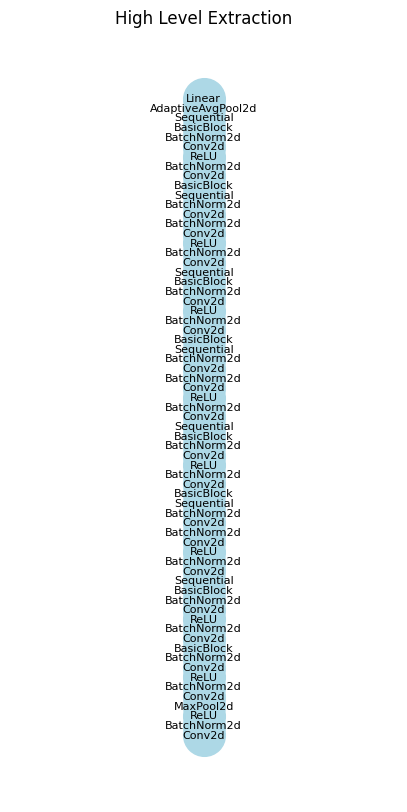

In [71]:
shown_modules = [nn.Conv2d, nn.MaxPool2d, nn.ReLU, nn.BatchNorm2d, nn.Linear, nn.Flatten]
split_modules = [nn.Sequential, nn.ModuleList, nn.ModuleDict]
graph_transformer = GraphTransformer()
graph_transformer.transform(model)
plot_graph(graph_transformer.graph, "High Level Extraction", graph_transformer.pos)

TODO: Beurteile dieses Ergebnis. Was ist gut und was fehlt? Weshalb es sich angenehm konfigurieren? -> software quality

In [67]:
print(inspect.getsource(model._forward_impl))

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


### Gedanken aus dem Treffen am 24.10

- TQDM Bibliothek für Progressbar nutzen
- 3 bis 4 Vorschläge für die Themenbezeichnung
- Liste was aufgesplittet werden soll und Liste was ignoriert werden soll als Parameter entgegennehmen
- Duckpunching vor und Nachteile betrachten und weshalb dies an gewissen Stellen gewählt wird statt der JIT trace Variante
- Alles erstmal behandeln und nichts ignorieren, sowohl bei forward Funktion Betrachtung als auch bei der children.modules Betrachtung (auch Operationen wie add)
- Als interface nach außen eine Methode bauen mit mehreren Parametern zum einstellen, statt high-level medium-level und low-level anzubieten
- Mit JIT und Module.children arbeiten und beides schriftlich beurteilen und vergleichen
- Mehr auf Software Engineering Prozess eingehen beim dokumentieren d.h. warum welches design gewählt wird und was die alternative wäre die nicht genommen wird + Begründung
- Weniger gendanken zur Visualisierung machen, mehr zur usability und software quality. Adjazenz matrix soll am ende rausgegeben werden.

For testing purpose we will now create a own custom neural network. We will successively make it more complex s.t. we can check our implementation for correctness

In [65]:
from torch import nn

class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU()
            ),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        self.conv1 = nn.Conv2d(3, 3, 20)
        self.pool1 = nn.MaxPool2d(3, 2)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(100)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


OrderedDict([('flatten', Flatten(start_dim=1, end_dim=-1)), ('layer1', Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (5): Linear(in_features=512, out_features=10, bias=True)
  (6): ReLU()
)), ('conv1', Conv2d(3, 3, kernel_size=(20, 20), stride=(1, 1))), ('pool1', MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)), ('relu', ReLU()), ('batchnorm1', BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))])
First transform method. Touched module:  with name flatten
Flatten(start_dim=1, end_dim=-1)
added to graph: flatten
First transform method. Touched module:  with name layer1
Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3)

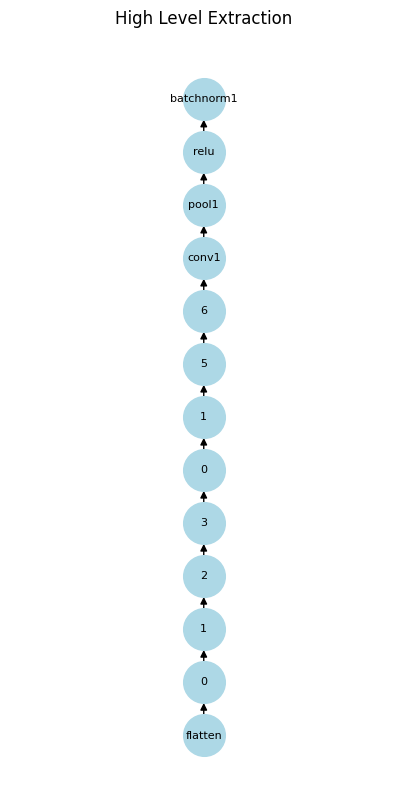

In [66]:
import matplotlib.pyplot as plt
import numpy as np

custom_model = CustomNN()
print(custom_model.__dict__.get("_modules"))
def plot_graph(graph, title, positions):
    labels = {node: graph.nodes[node]['name'] for node in graph.nodes()}
    fig, ax = plt.subplots(figsize=(5, 10))
    nx.draw(graph, positions, labels=labels, with_labels=True, node_size=900, node_color='lightblue', font_size=8, ax=ax)
    plt.title(title)
    plt.show()
    
g, p = transform(custom_model)
print(g)
plot_graph(g, "High Level Extraction", p)